In [1]:
import numpy as np
from astropy.cosmology import Planck15 as cosmo
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
Msun=1.98847*pow(10,30)#kg, solar mass
c_v=2.99792458*pow(10,8)#m/s
G=6.6740831*pow(10,-11)#m^3/(kg*s^2)
Mpc = 30.85734528 * pow(10, 21)#unit:m
CH=1000/(30.85734528*pow(10,21))#unit:km/Mpc
Dc=cosmo.comoving_transverse_distance
Da=cosmo.angular_diameter_distance
Daa=cosmo.angular_diameter_distance_z1z2
tz=Dc


In [2]:
class mutiplane(object):

    def __init__(self,lenx_list,leny_list,lenz_list,lenm_list,q,phi,z_sou,windows,n_pixel,):
        self.lenx_list = lenx_list
        self.lenz_list = lenz_list
        self.leny_list = leny_list
        self.lenm_list = lenm_list
        self.q=q
        self.phi=phi
        self.z_sou=z_sou
        self.windows=windows
        self.n_pixel=n_pixel

    def m200tosigmav(self,m,z):
        '''
        m:mass,unit:solar mass
        z:redshift
        '''
        sigma_v = np.power(m * Msun * 10 * G * np.array(cosmo.H(z)) * CH, 1 / 3) / np.sqrt(2)  # cite:mo,mao,white(1998)
        return sigma_v / 1000  # 单位km/s

    def sis_sigma_vtotheta_E(self, sigma_v,z_len,z_source):
        """
        converts the velocity dispersion into an Einstein radius for a SIS profile
        sigma_v: velocity dispersion (km/s)
        theta_E unit:arcsec
        """
        theta_E = 4 * np.pi * (sigma_v * 1000. / c_v) ** 2 * Daa(z_len,z_source).value / Da(z_source).value *3600*(360/2/np.pi)

        return theta_E

    def M_2002thate_200(self,m,z):
        r_200 = self.m200tosigmav(m,z) * np.sqrt(2) / (10 * np.array(cosmo.H(z)))  # cite:Mo,Mao,White(1998)
        theta_200 = r_200 / np.array(Da(z)) * (360/2/np.pi)* 60 * 60
        return theta_200  # unit:arcsec

    def M_2002R_200(self,m, z):
        r_200 = self.m200tosigmav(m,z) * np.sqrt(2) / (10 * np.array(cosmo.H(z)))  # cite:Mo,Mao,White(1998)
        return r_200  # unit:arcsec

    def defl_sie(self, x, y, center_x, center_y, thetaE, phi, q):  # deflection angle of sie,unit:arcsec
        '''
        xcen,ycen: the center coordinates of point mass
        phi:direction of major axis,unit:deg
        q:ratio of major to minor axis
        thetaE: einstein radius in unit of arcsec
        cite: equation (8) in Keeton&Kochanek 1998,s=0
        '''
        if q >= 1:
            q = 0.999999

        s = 0.0000000001
        x_shift = x - center_x
        y_shift = y - center_y
        cos_phi = np.cos(phi)
        sin_phi = np.sin(phi)

        x = (cos_phi * x_shift + sin_phi * y_shift)
        y = (-sin_phi * x_shift + cos_phi * y_shift)
        theta_E_conv = thetaE / (np.sqrt((1. + q ** 2.) / (2. * q)))
        b = theta_E_conv * np.sqrt((1. + q ** 2.) / 2.)
        s = s / np.sqrt(q)
        psi = np.sqrt(q ** 2. * (s ** 2. + x ** 2.) + y ** 2.)+1e-8
        f_x = b / np.sqrt(1. - q ** 2.) * np.arctan(np.sqrt(1. - q ** 2) * x / (psi + s))
        f_y = b / np.sqrt(1. - q ** 2.) * np.arctanh(np.sqrt(1. - q ** 2) * y / (psi + q ** 2. * s))
        f_x_ = (np.cos(-phi) * f_x + np.sin(-phi) * f_y)
        f_y_ = (-np.sin(-phi) * f_x + np.cos(-phi) * f_y)

        return f_x_, f_y_

    def raytracing_interpation(self):
        '''
        :param lenx_list: numoy_array,x_positions of lenses,unit:arcsec
        :param leny_list: numoy_array,y_positions of lenses
        :param lenz_list: numoy_array,redshift of lenses
        :param lenm_list: numoy_array,mass of lenses,unit:solar mass
        :param q: numoy_array,ratio of major to minor axis of lenses
        :param phi: numoy_array,direction of major axis of lenses
        :param z_sou: source redshift
        :param windows: sidelength of ray-tracing map,unit:arcsec
        :param n_pixel: pixel number along the side
        :return: light ray position
        '''

        z_array=np.append(self.lenz_list,self.z_sou)
        z_array=np.sort(z_array)
        xmin = -self.windows/2
        xmax =self.windows/2

        x = np.linspace(xmin, xmax, self.n_pixel)
        len1rayx_ori, len1rayy_ori = np.meshgrid(x, x)
        len1rayx=len1rayx_ori
        len1rayy=len1rayy_ori
        xi_1_x=len1rayx*Da(z_array[0]).value/(360/(2*np.pi))/3600
        xi_1_y=len1rayy*Da(z_array[0]).value/(360/(2*np.pi))/3600


        alpha_x = np.zeros(len1rayx.shape)
        alpha_y = np.zeros(len1rayx.shape)
        alpha_x_list=[]
        alpha_y_list=[]
        theta_e=self.sis_sigma_vtotheta_E(self.m200tosigmav(self.lenm_list[0],z_array[0]),z_array[0],z_array[1])
        center_x = self.lenx_list[0]
        center_y = self.leny_list[0]
        alpha_x_,alpha_y_=self.defl_sie(x=len1rayx, y=len1rayy, center_x=center_x,
                                           center_y=center_y,phi=self.phi[0],q=self.q[0],thetaE=theta_e)
        alpha_x=alpha_x+alpha_x_
        alpha_y=alpha_y+alpha_y_


        alpha_x = alpha_x * Da(z_array[1]).value / Daa(z_array[0], z_array[1]).value
        alpha_y = alpha_y * Da(z_array[1]).value / Daa(z_array[0], z_array[1]).value
        alpha_x_list.append(alpha_x)
        alpha_y_list.append(alpha_y)
        xi_j2_x = xi_1_x * Da(z_array[1]).value / Da(z_array[0]).value -Daa(z_array[0],z_array[1]).value*alpha_x/(360/2/np.pi)/3600
        xi_j2_y = xi_1_y * Da(z_array[1]).value / Da(z_array[0]).value - Daa(z_array[0], z_array[1]).value * alpha_y/(360/2/np.pi)/3600
        len2rayx=xi_j2_x/Da(z_array[1]).value*(360/2/np.pi)*3600
        len2rayy=xi_j2_y/Da(z_array[1]).value*(360/2/np.pi)*3600


        for j in range(len(lenx_list)-1):
            alpha_x = np.zeros(len1rayx.shape)
            alpha_y = np.zeros(len1rayx.shape)
            theta_e = self.sis_sigma_vtotheta_E(self.m200tosigmav(self.lenm_list[j+1], z_array[j+1]), z_array[j+1], z_array[j+2])
            alpha_x_, alpha_y_ = self.defl_sie(x=len1rayx, y=len1rayy, center_x=self.lenx_list[j+1],
                                               center_y=self.leny_list[j+1], phi=self.phi[j+1], q=self.q[j+1],thetaE=theta_e)


            alpha_x = alpha_x + alpha_x_
            alpha_y = alpha_y + alpha_y_
            alpha_x=alpha_x*Da(z_array[j+2]).value/Daa(z_array[j+1],z_array[j+2]).value
            alpha_y = alpha_y * Da(z_array[j + 2]).value / Daa(z_array[j + 1], z_array[j + 2]).value

            f_x = RegularGridInterpolator((x, x), alpha_x,method="linear", bounds_error=False)

            f_y = RegularGridInterpolator((x, x), alpha_y,method="linear", bounds_error=False)
            alpha_x = f_x((len2rayy,len2rayx))
            alpha_y=f_y(( len2rayy,len2rayx))

            alpha_x_list.append(alpha_x)
            alpha_y_list.append(alpha_y)
            sum_x=np.zeros(alpha_x.shape)
            sum_y = np.zeros(alpha_x.shape)


            for p in range(j+2):
                sum_x=sum_x+Daa(z_array[p],z_array[j+2]).value*alpha_x_list[p]
                sum_y = sum_y+ Daa(z_array[p], z_array[j + 2]).value * alpha_y_list[p]
            xi_j_x=Da(z_array[j+2]).value/Da(z_array[0]).value*xi_1_x-sum_x/(360/2/np.pi)/3600
            xi_j_y = Da(z_array[j + 2]).value / Da(z_array[0]).value * xi_1_y - sum_y/(360/2/np.pi)/3600
            len2rayx=xi_j_x/Da(z_array[j+2]).value*(360/2/np.pi)*3600
            len2rayy=xi_j_y/Da(z_array[j+2]).value*(360/2/np.pi)*3600

            # if j==len(lenx_list)-3:
            #     position_x=len2rayx
            #     position_y = len2rayy

        return len2rayx,len2rayy

    def raytracing(self):

        lenx_list=self.lenx_list
        lenz_list=self.lenz_list
        leny_list=self.leny_list
        lenm_list=self.lenm_list
        q=self.q
        phi=self.phi
        soutestz=self.z_sou
        windows=self.windows
        npix=self.n_pixel
        e=1-q
        value = np.array(lenz_list)
        indexer = value.argsort()
        lenz_list = lenz_list[indexer]
        lenm_list = lenm_list[indexer]
        lenx_list = lenx_list[indexer]
        leny_list = leny_list[indexer]
        e = e[indexer]
        phi = phi[indexer]
        lenz_list = list(lenz_list)
        lenz_list.append(soutestz)
        lenz_list = np.array(lenz_list)
        len1z = lenz_list[0]
        len2z = lenz_list[1]
        len1x = lenx_list[0]
        len1y = leny_list[0]
        xmin = -windows / 2
        xmax = windows / 2
        x = np.linspace(xmin, xmax, npix)
        len1rayx, len1rayy = np.meshgrid(x, x)

        theta_E = self.sis_sigma_vtotheta_E(self.m200tosigmav(lenm_list[0], lenz_list[0]), len1z, len2z)
        alpha_x, alpha_y = self.defl_sie(x=len1rayx, y=len1rayy, thetaE=theta_E, q=q[0], phi=phi[0], center_x=len1x,
                                    center_y=len1y)
        len2rayx = len1rayx - alpha_x
        len2rayy = len1rayy - alpha_y
        lenrayx_list = []
        lenrayy_list = []
        lenrayx_list.append(len1rayx)
        lenrayy_list.append(len1rayy)
        lenrayx_list.append(len2rayx)
        lenrayy_list.append(len2rayy)
        n = len(leny_list)
        if (n > 1):
            for i in range(n - 1):
                cenx = np.array((tz(lenz_list[i + 1]) * lenx_list[i + 1] - tz(lenz_list[i]) * lenrayx_list[0]) / (
                            tz(lenz_list[i + 1]) - tz(lenz_list[i])))
                ceny = np.array((tz(lenz_list[i + 1]) * leny_list[i + 1] - tz(lenz_list[i]) * lenrayy_list[0]) / (
                            tz(lenz_list[i + 1]) - tz(lenz_list[i])))
                x = np.array((lenrayx_list[1] * tz(lenz_list[i + 1]) - lenrayx_list[0] * tz(lenz_list[i])) / (
                            tz(lenz_list[i + 1]) - tz(lenz_list[i])))
                y = np.array((lenrayy_list[1] * tz(lenz_list[i + 1]) - lenrayy_list[0] * tz(lenz_list[i])) / (
                            tz(lenz_list[i + 1]) - tz(lenz_list[i])))
                theta_E = self.sis_sigma_vtotheta_E(self.m200tosigmav(lenm_list[i+1], lenz_list[i+1]),  lenz_list[i+1],  lenz_list[i+2])*Da(lenz_list[i+2]).value/Daa(lenz_list[i],lenz_list[i+2]).value

                alpha_x, alpha_y = self.defl_sie(x=x, y=y, thetaE=theta_E, q=q[i + 1], phi=phi[i + 1], center_x=cenx,
                                            center_y=ceny)
                len2rayx = ((x - alpha_x) * (tz(lenz_list[i + 2]).value - tz(lenz_list[i]).value) + lenrayx_list[
                    0] * tz(lenz_list[i]).value) / tz(lenz_list[i + 2]).value
                len2rayy = ((y - alpha_y) * (tz(lenz_list[i + 2]) - tz(lenz_list[i])) + lenrayy_list[0] * tz(
                    lenz_list[i])) / tz(lenz_list[i + 2])
                lenrayx_list[0] = lenrayx_list[1]
                lenrayx_list[1] = len2rayx
                lenrayy_list[0] = lenrayy_list[1]
                lenrayy_list[1] = len2rayy

        return len2rayx, len2rayy


In [3]:
'''构建sersic亮度分布函数'''
def sersic_1d(r, r_eff, i_eff, n):
    """
    r: distance from the galaxy center
    r_eff: half-light radius (or effective radius) of galaxy
    i_eff: the intensity at r_eff
    """
    if n >= 0.36: # from Ciotti & Bertin 1999, truncated to n^-3
        k=2.0*n-1./3+4./(405.*n)+46./(25515.*n**2.)+131./(1148175.*n**3.)
    else: # from MacArthur et al. 2003
        k=0.01945-0.8902*n+10.95*n**2.-19.67*n**3.+13.43*n**4.
    return i_eff*np.exp(-k*((r/r_eff)**(1./n)-1.0))

def xy_transform(x, y, xcen, ycen, phi):
    """
    Clockwise 2D-rotational matrix
    xcen,ycen: the rotation center coordinate
    phi: rotation angle in degree unit.
    """
    xnew=(x-xcen)*np.cos(np.pi*phi/180.0)+(y-ycen)*np.sin(np.pi*phi/180.0)
    ynew=-(x-xcen)*np.sin(np.pi*phi/180.0)+(y-ycen)*np.cos(np.pi*phi/180.0)
    return (xnew, ynew)

def grid_to_elliptical_radii(x, y, xcen, ycen, phi, axis_ratio):
    """
    Genrate the elliptical radii from grid
    xcen,ycen: the centre of image
    phi: positional angle
    axis_ratio: the axis-ratio of ecllipse (b/a)
    """
    xnew, ynew = xy_transform(x, y, xcen, ycen, phi)
    r=np.sqrt(axis_ratio*xnew**2. + ynew**2./axis_ratio) #
    return r

def sersic_2d(x, y, xcen, ycen, phi, axis_ratio, i_eff, r_eff, n):
    r = grid_to_elliptical_radii(x, y, xcen, ycen, phi, axis_ratio)
    return sersic_1d(r, r_eff, i_eff, n)


In [4]:
'''配置透镜以及源亮度轮廓参数，进行ray-tracing模拟'''
lenx_list=np.array([0.,-0.])
leny_list=np.array([-0.,0.])
lenz_list=np.array([0.3,0.6])
lenm_list=np.array([1e13,1e13])
q=np.array([0.7,0.95])
phi=np.array([270,130])
Mutiplane=mutiplane(lenx_list=lenx_list,leny_list=leny_list,lenm_list=lenm_list,lenz_list=lenz_list,q=q,phi=phi,z_sou=1,windows=10,n_pixel=500)

x,y=Mutiplane.raytracing()
image_2d_src_plane = sersic_2d(
    x=x,
    y=y,
    xcen=0,
    ycen=0,
    phi=90,
    axis_ratio=0.9,
    i_eff=1.0,
    r_eff=0.1,
    n=1.0
)

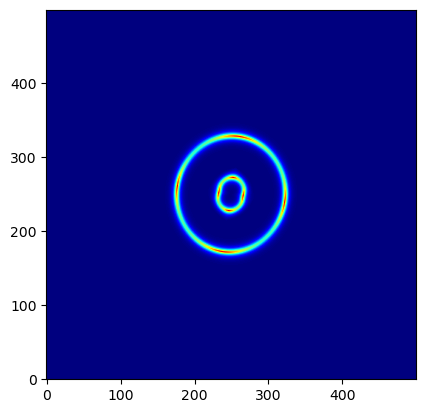

In [5]:
plt.imshow(image_2d_src_plane,cmap='jet', origin='lower')
plt.show()